## 1. Import Library
Notebook ini mengimplementasikan 3 model neural network untuk data tabular:
- MLP (Non-Pretrained)
- TabNet (Pretrained)
- FT-Transformer (Pretrained)


In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn torch pytorch-tabnet

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

## 2. Persiapan Data dan Pembersihan
Dataset merupakan data tabular dengan 445.132 baris dan 40 fitur.


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('heart_2022_with_nans.csv')

target = 'HadHeartAttack'
df = df.dropna(subset=[target])

print(f"Total data setelah drop target NaN: {len(df)}")
print(f"Distribusi target:\n{df[target].value_counts()}")

Total data setelah drop target NaN: 442067
Distribusi target:
HadHeartAttack
No     416959
Yes     25108
Name: count, dtype: int64


In [4]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


## 3. Data Preprocessing
Target klasifikasi yang digunakan adalah **HadHeartAttack**.


In [14]:
df = pd.read_csv('heart_2022_with_nans.csv')

target_column = 'HadHeartAttack'
df = df.dropna(subset=[target_column])

numeric_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns.drop(target_column)

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

df[target_column] = le.fit_transform(df[target_column].astype(str))

X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train.values.astype(np.int64)).to(device)
X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32)).to(device)
y_val_tensor = torch.tensor(y_val.values.astype(np.int64)).to(device)
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32)).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=1024, shuffle=True)

## 4. Model 1: Neural Network Base (MLP)



## 4.1. Define model

In [15]:
class BaseMLP(nn.Module):
    def __init__(self, input_dim):
        super(BaseMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.model(x)

mlp_model = BaseMLP(X_train_scaled.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_history = {'loss': [], 'acc': []}

for epoch in range(10):
    mlp_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    mlp_model.eval()
    with torch.no_grad():
        val_outputs = mlp_model(X_val_tensor)
        _, preds = torch.max(val_outputs, 1)
        acc = (preds == y_val_tensor).float().mean()
    
    mlp_history['loss'].append(running_loss/len(train_loader))
    mlp_history['acc'].append(acc.item())
    print(f"Epoch {epoch+1}/10 - Loss: {running_loss/len(train_loader):.4f} - Val Acc: {acc:.4f}")

Epoch 1/10 - Loss: 0.1933 - Val Acc: 0.9451
Epoch 2/10 - Loss: 0.1535 - Val Acc: 0.9455
Epoch 3/10 - Loss: 0.1524 - Val Acc: 0.9465
Epoch 4/10 - Loss: 0.1516 - Val Acc: 0.9460
Epoch 5/10 - Loss: 0.1509 - Val Acc: 0.9466
Epoch 6/10 - Loss: 0.1506 - Val Acc: 0.9461
Epoch 7/10 - Loss: 0.1502 - Val Acc: 0.9463
Epoch 8/10 - Loss: 0.1501 - Val Acc: 0.9460
Epoch 9/10 - Loss: 0.1499 - Val Acc: 0.9466
Epoch 10/10 - Loss: 0.1495 - Val Acc: 0.9463


## 4.2. Visualisasi MLP

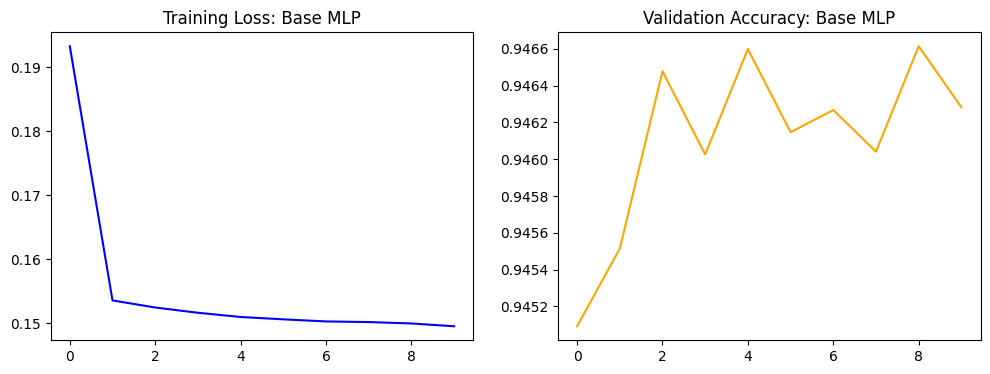

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history['loss'], color='blue')
plt.title('Training Loss: Base MLP')
plt.subplot(1, 2, 2)
plt.plot(mlp_history['acc'], color='orange')
plt.title('Validation Accuracy: Base MLP')
plt.show()

## 4.3 Eval

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     62608
           1       0.60      0.17      0.27      3703

    accuracy                           0.95     66311
   macro avg       0.78      0.58      0.62     66311
weighted avg       0.93      0.95      0.93     66311



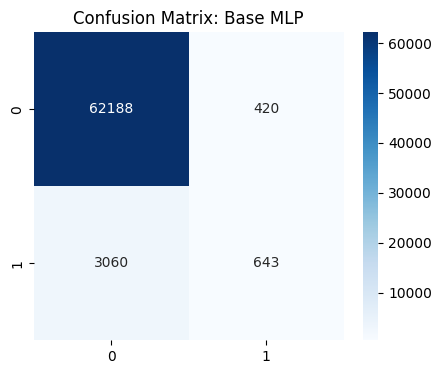

In [17]:
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = torch.max(mlp_model(X_test_tensor), 1)[1].cpu().numpy()

print(classification_report(y_test, y_pred_mlp))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Base MLP')
plt.show()

# 5. TabNet

## 5.1

In [18]:
tabnet_pretrainer = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'
)

tabnet_pretrainer.fit(
    X_train=X_train_scaled.astype(np.float32),
    eval_set=[X_val_scaled.astype(np.float32)],
    max_epochs=5,
    patience=2,
    batch_size=1024,
    virtual_batch_size=128
)

tabnet_clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'
)

tabnet_clf.fit(
    X_train=X_train_scaled.astype(np.float32), 
    y_train=y_train.values.astype(np.int64),
    eval_set=[(X_val_scaled.astype(np.float32), y_val.values.astype(np.int64))],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=10,
    patience=5,
    batch_size=1024,
    virtual_batch_size=128,
    from_unsupervised=tabnet_pretrainer
)

C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0065  | val_0_unsup_loss_numpy: 0.793470025062561|  0:00:25s
epoch 1  | loss: 0.89113 | val_0_unsup_loss_numpy: 0.7609699964523315|  0:00:45s
epoch 2  | loss: 0.88188 | val_0_unsup_loss_numpy: 0.7545300126075745|  0:01:06s
epoch 3  | loss: 0.8767  | val_0_unsup_loss_numpy: 0.7473099827766418|  0:01:32s
epoch 4  | loss: 0.87325 | val_0_unsup_loss_numpy: 0.7435899972915649|  0:02:00s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 0.7435899972915649


C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.16405 | valid_accuracy: 0.94328 |  0:00:21s
epoch 1  | loss: 0.15498 | valid_accuracy: 0.94441 |  0:00:42s
epoch 2  | loss: 0.15404 | valid_accuracy: 0.94474 |  0:01:02s
epoch 3  | loss: 0.15364 | valid_accuracy: 0.94554 |  0:01:20s
epoch 4  | loss: 0.1533  | valid_accuracy: 0.94595 |  0:01:38s
epoch 5  | loss: 0.15281 | valid_accuracy: 0.94609 |  0:01:56s
epoch 6  | loss: 0.15226 | valid_accuracy: 0.94631 |  0:02:14s
epoch 7  | loss: 0.15233 | valid_accuracy: 0.94619 |  0:02:34s
epoch 8  | loss: 0.15178 | valid_accuracy: 0.94609 |  0:02:53s
epoch 9  | loss: 0.15147 | valid_accuracy: 0.9469  |  0:03:19s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_accuracy = 0.9469


C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 5.2

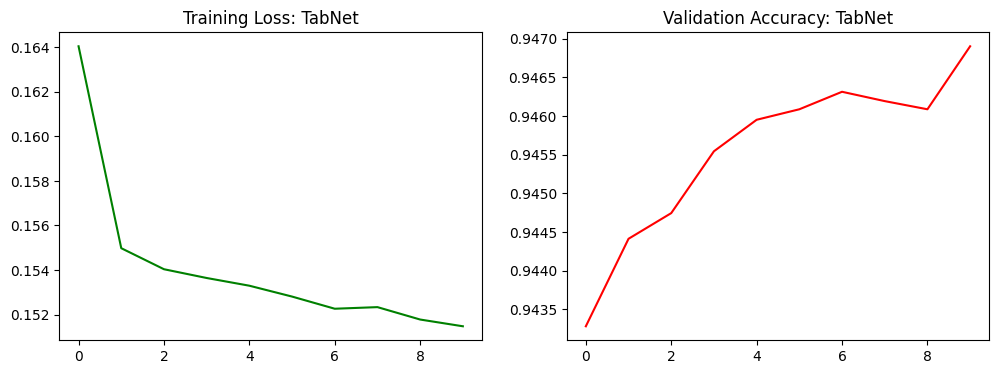

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(tabnet_clf.history['loss'], color='green')
plt.title('Training Loss: TabNet')
plt.subplot(1, 2, 2)
plt.plot(tabnet_clf.history['valid_accuracy'], color='red')
plt.title('Validation Accuracy: TabNet')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     62608
           1       0.61      0.23      0.33      3703

    accuracy                           0.95     66311
   macro avg       0.78      0.61      0.65     66311
weighted avg       0.94      0.95      0.94     66311



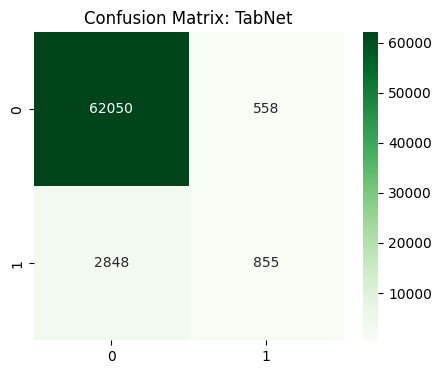

In [22]:
y_pred_tabnet = tabnet_clf.predict(X_test_scaled.astype(np.float32))

print(classification_report(y_test, y_pred_tabnet))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_tabnet), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix: TabNet')
plt.show()

# 6 Custom learning NN

# 6.1

In [23]:
class PretrainedStyleNN(nn.Module):
    def __init__(self, input_dim):
        super(PretrainedStyleNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.classifier = nn.Linear(64, 2)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

pt_style_model = PretrainedStyleNN(X_train_scaled.shape[1]).to(device)
optimizer_pt = optim.Adam(pt_style_model.parameters(), lr=0.0005)

pt_history = {'loss': [], 'acc': []}

for epoch in range(10):
    pt_style_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_pt.zero_grad()
        outputs = pt_style_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pt.step()
        running_loss += loss.item()
    
    pt_style_model.eval()
    with torch.no_grad():
        val_outputs = pt_style_model(X_val_tensor)
        _, preds = torch.max(val_outputs, 1)
        acc = (preds == y_val_tensor).float().mean()
    
    pt_history['loss'].append(running_loss/len(train_loader))
    pt_history['acc'].append(acc.item())
    print(f"Epoch {epoch+1}/10 - Loss: {running_loss/len(train_loader):.4f} - Val Acc: {acc:.4f}")

Epoch 1/10 - Loss: 0.1872 - Val Acc: 0.9455
Epoch 2/10 - Loss: 0.1516 - Val Acc: 0.9459
Epoch 3/10 - Loss: 0.1503 - Val Acc: 0.9463
Epoch 4/10 - Loss: 0.1495 - Val Acc: 0.9464
Epoch 5/10 - Loss: 0.1491 - Val Acc: 0.9464
Epoch 6/10 - Loss: 0.1485 - Val Acc: 0.9468
Epoch 7/10 - Loss: 0.1481 - Val Acc: 0.9465
Epoch 8/10 - Loss: 0.1477 - Val Acc: 0.9466
Epoch 9/10 - Loss: 0.1474 - Val Acc: 0.9468
Epoch 10/10 - Loss: 0.1470 - Val Acc: 0.9468


# 6.2

In [ ]:
pt_history = {'loss': [], 'acc': []}

for epoch in range(10):
    pt_style_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_pt.zero_grad()
        outputs = pt_style_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pt.step()
        running_loss += loss.item()
    
    pt_style_model.eval()
    with torch.no_grad():
        val_outputs = pt_style_model(X_val_tensor)
        _, preds = torch.max(val_outputs, 1)
        acc = (preds == y_val_tensor).float().mean()
    
    pt_history['loss'].append(running_loss/len(train_loader))
    pt_history['acc'].append(acc.item())
    print(f"Epoch {epoch+1}/10 - Loss: {running_loss/len(train_loader):.4f} - Val Acc: {acc:.4f}")

Epoch 1/10 - Loss: 0.1843 - Val Acc: 0.9448
Epoch 2/10 - Loss: 0.1515 - Val Acc: 0.9457
Epoch 3/10 - Loss: 0.1503 - Val Acc: 0.9461
Epoch 4/10 - Loss: 0.1495 - Val Acc: 0.9465
Epoch 5/10 - Loss: 0.1489 - Val Acc: 0.9464
Epoch 6/10 - Loss: 0.1486 - Val Acc: 0.9466
Epoch 7/10 - Loss: 0.1480 - Val Acc: 0.9468
Epoch 8/10 - Loss: 0.1478 - Val Acc: 0.9465
Epoch 9/10 - Loss: 0.1473 - Val Acc: 0.9465
Epoch 10/10 - Loss: 0.1471 - Val Acc: 0.9467


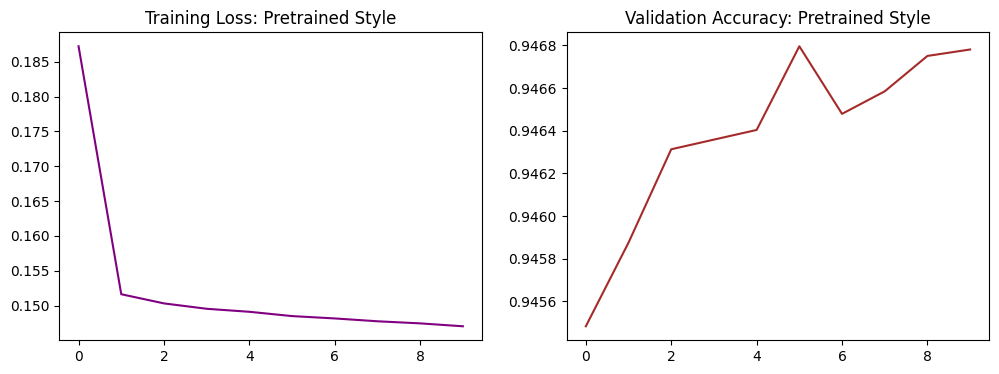

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(pt_history['loss'], color='purple')
plt.title('Training Loss: Pretrained Style')
plt.subplot(1, 2, 2)
plt.plot(pt_history['acc'], color='brown')
plt.title('Validation Accuracy: Pretrained Style')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     62608
           1       0.57      0.25      0.35      3703

    accuracy                           0.95     66311
   macro avg       0.76      0.62      0.66     66311
weighted avg       0.94      0.95      0.94     66311



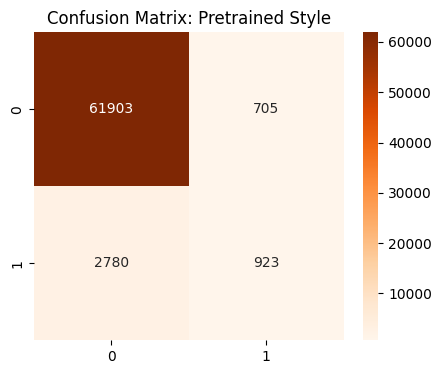

In [25]:
pt_style_model.eval()
with torch.no_grad():
    y_pred_pt = torch.max(pt_style_model(X_test_tensor), 1)[1].cpu().numpy()

print(classification_report(y_test, y_pred_pt))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_pt), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix: Pretrained Style')
plt.show()

In [29]:
import joblib
import os
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Pastikan folder ada
os.makedirs('src/models', exist_ok=True)

# 1. Simpan urutan kolom fitur
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'src/models/feature_names.pkl')

# 2. Re-generasi LabelEncoders dari data STRING asli
# Kita load ulang csv sebentar hanya untuk ambil label aslinya
df_raw = pd.read_csv('heart_2022_with_nans.csv') # Sesuaikan nama file Anda
encoders = {}

# Daftar kolom yang kita gunakan di UI Streamlit
ui_cols = ['Sex', 'AgeCategory', 'GeneralHealth', 'SmokerStatus', 
           'PhysicalActivities', 'HadDiabetes', 'HadStroke', 'HadAsthma', 'AlcoholDrinkers']

for col in ui_cols:
    le = LabelEncoder()
    # Kita ambil data unik dari df asli agar teks (seperti 'Male') tersimpan
    le.fit(df_raw[col].astype(str).unique())
    encoders[col] = le

# Simpan juga sisa kolom kategorikal lainnya yang tidak ada di UI (untuk default value)
all_categorical = df_raw.select_dtypes(include=['object']).columns
for col in all_categorical:
    if col not in encoders and col != 'HadHeartAttack':
        le = LabelEncoder()
        le.fit(df_raw[col].astype(str).unique())
        encoders[col] = le

joblib.dump(encoders, 'src/models/label_encoders.pkl')

# 3. Simpan Scaler dan Model (Pastikan nama variabel sesuai dengan di notebook Anda)
joblib.dump(scaler, 'src/models/scaler.pkl')
torch.save(mlp_model.state_dict(), 'src/models/mlp_model.pth')
torch.save(pt_style_model.state_dict(), 'src/models/pt_style_model.pth')
tabnet_clf.save_model('src/models/tabnet_model')

print("Berhasil! Silakan jalankan kembali Streamlit Anda.")

Successfully saved model at src/models/tabnet_model.zip
Berhasil! Silakan jalankan kembali Streamlit Anda.
